In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import GadiClient 
import dask
import glob
import numpy as np
import dask
from merge_data import last_day_of_month
import os
import datetime as dt
import pandas as pd
from merge_data import get_env_clusters, last_day_of_month
from era5_spatial_cluster import transform_era5, era5_clustering

def calc_bdsd(ds):
    ds = ds.assign(bdsd = 1 /
                   ( 1 + np.exp( -(6.1e-02*ds["ebwd"] + 1.5e-01*ds["Umean800_600"] + 9.4e-01*ds["lr13"] + 3.9e-02*ds["rhmin13"] +
                                   1.7e-02*ds["srhe_left"] +3.8e-01*ds["q_melting"] +4.7e-04*ds["eff_lcl"] - 1.3e+01 ) ) ) )
    return ds

In [2]:
GadiClient.GadiClient()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38031,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:35903,Total threads: 1
Dashboard: /proxy/39225/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:39235,


In [3]:
dask.config.set({'array.slicing.split_large_chunks': False})

In [45]:
#Load the ACCESS-forced historical BARPA data. BARPA-R data is from wrf_non_parallel.py. BARPAC data is from barpa_spatial_scw.py

def load_hist(y1, y2):
    files_barpar = []
    files_barpac = []
    for y in np.arange(y1,y2+1):
        for m in [12,1,2]:
            date = dt.datetime(y,m,1)
            path_barpar = "/g/data/eg3/ab4502/ExtremeWind/aus/barpa_access/barpa_access_"+date.strftime("%Y%m%d")+"_"+last_day_of_month(dt.datetime(y,m,1)).strftime("%Y%m%d")+".nc"
            path_barpac = "/scratch/eg3/ab4502/barpa_scw_ACCESS1-0_historical_0_"+date.strftime("%Y%m%d")+"_"+last_day_of_month(dt.datetime(y,m,1)).strftime("%Y%m%d")+".nc"        
            if (date>=dt.datetime(1985,12,1)) & (date < dt.datetime(2005,3,1)):
                if (os.path.isfile(path_barpar)):
                    files_barpar.append(path_barpar)
                if (os.path.isfile(path_barpac)):                
                    files_barpac.append(path_barpac)            
            else:
                print("Skipping "+date.strftime("%Y%m%d")+"...")

    #Load BARPAR
    barpar_hist = xr.open_mfdataset(files_barpar).sel({"lat":slice(-44.47,-28.9),"lon":slice(135.5,156.0)})
    
    #Do environmental clustering
    cluster_mod, cluster_input = get_env_clusters()
    s06, qmean01, lr13, Umean06 = transform_era5(barpar_hist, cluster_mod, cluster_input)
    s06 = s06.persist(); qmean01 = qmean01.persist(); lr13 = lr13.persist(); Umean06 = Umean06.persist()
    cluster = era5_clustering(s06, qmean01, lr13, Umean06, barpar_hist, cluster_mod).persist()

    #Mask ocean
    lsm = xr.open_dataset("/g/data/tp28/BARPA/trials/BARPA-EASTAUS_12km/static/lnd_mask-BARPA-EASTAUS_12km.nc").rename({"latitude":"lat","longitude":"lon"}).interp_like(cluster,method="nearest")
    cluster = xr.where(lsm.lnd_mask==1,cluster,np.nan)
    
    #Load barpac
    barpac_hist = xr.open_mfdataset(files_barpac).sel({"latitude":slice(-44.47,-28.9),"longitude":slice(135.5,156.0)})   
    
    return output_bdsd(cluster), barpac_hist

def output_bdsd(ds):
    
    dim=("lat","lon","date")
    out_ds = xr.Dataset({
            "cluster0":(dim, (ds.cluster==0).groupby(ds["time"].dt.date).max().values),
            "cluster1":(dim, (ds.cluster==2).groupby(ds["time"].dt.date).max().values),
            "cluster2":(dim, (ds.cluster==3).groupby(ds["time"].dt.date).max().values),    
            "clusterall_bdsd":(dim, (ds.bdsd>=0.83).groupby(ds["time"].dt.date).max().values),    
            "cluster0_bdsd":(dim, ((ds.cluster==0) & (ds.bdsd>=0.83)).groupby(ds["time"].dt.date).max().values),
            "cluster1_bdsd":(dim, ((ds.cluster==1) & (ds.bdsd>=0.83)).groupby(ds["time"].dt.date).max().values),
            "cluster2_bdsd":(dim, ((ds.cluster==2) & (ds.bdsd>=0.83)).groupby(ds["time"].dt.date).max().values),
        },
        coords={"lat":(("lat"), ds.lat.values), "lon":(("lon"), ds.lon.values), "date":np.unique(ds.time.dt.date.values)}) 
    
    return out_ds

def load_rcp(y1, y2):
    files_barpar = []
    files_barpac = []
    for y in np.arange(y1,y2+1):
        for m in [12,1,2]:
            date = dt.datetime(y,m,1)
            path_barpar = "/g/data/eg3/ab4502/ExtremeWind/aus/barpa_access/barpa_access_"+date.strftime("%Y%m%d")+"_"+last_day_of_month(dt.datetime(y,m,1)).strftime("%Y%m%d")+".nc"
            path_barpac = "/scratch/eg3/ab4502/barpa_scw_ACCESS1-0_rcp85_0_"+date.strftime("%Y%m%d")+"_"+last_day_of_month(dt.datetime(y,m,1)).strftime("%Y%m%d")+".nc"        
            if (date>=dt.datetime(2039,12,1)) & (date < dt.datetime(2059,3,1)):
                if (os.path.isfile(path_barpar)):
                    files_barpar.append(path_barpar)
                if (os.path.isfile(path_barpac)):                
                    files_barpac.append(path_barpac)            
            else:
                print("Skipping "+date.strftime("%Y%m%d")+"...")                

    #Load BARPAR
    barpar_hist = xr.open_mfdataset(files_barpar).sel({"lat":slice(-44.47,-28.9),"lon":slice(135.5,156.0)})
    
    #Do environmental clustering
    cluster_mod, cluster_input = get_env_clusters()
    s06, qmean01, lr13, Umean06 = transform_era5(barpar_hist, cluster_mod, cluster_input)
    s06 = s06.persist(); qmean01 = qmean01.persist(); lr13 = lr13.persist(); Umean06 = Umean06.persist()
    cluster = era5_clustering(s06, qmean01, lr13, Umean06, barpar_hist, cluster_mod).persist()

    #Mask ocean
    lsm = xr.open_dataset("/g/data/tp28/BARPA/trials/BARPA-EASTAUS_12km/static/lnd_mask-BARPA-EASTAUS_12km.nc").rename({"latitude":"lat","longitude":"lon"}).interp_like(cluster,method="nearest")
    cluster = xr.where(lsm.lnd_mask==1,cluster,np.nan)
    
    #Load barpac
    barpac_hist = xr.open_mfdataset(files_barpac).sel({"latitude":slice(-44.47,-28.9),"longitude":slice(135.5,156.0)})
    
    return output_bdsd(cluster), barpac_hist
    
barpar_hist, barpac_hist = load_hist(2004,2005)
barpar_rcp, barpac_rcp = load_rcp(2058,2059)

Skipping 20051201...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Skipping 20591201...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [40]:
y1=2000
y2=2002

files_barpar = []
for y in np.arange(y1,y2+1):
    for m in [12,1,2]:
        date = dt.datetime(y,m,1)
        path_barpar = "/g/data/eg3/ab4502/ExtremeWind/aus/barpa_access/barpa_access_"+date.strftime("%Y%m%d")+"_"+last_day_of_month(dt.datetime(y,m,1)).strftime("%Y%m%d")+".nc"
        if (date>=dt.datetime(1985,12,1)) & (date < dt.datetime(2005,3,1)):
            if (os.path.isfile(path_barpar)):
                files_barpar.append(path_barpar)          
        else:
            print("Skipping "+date.strftime("%Y%m%d")+"...")

#Resample the BARPA-R BDSD to daily max, and mask ocean points
barpar_hist = xr.open_mfdataset(files_barpar).sel({"lat":slice(-44.47,-28.9),"lon":slice(135.5,156.0)})
#bdsd = barpar_hist["bdsd"].coarsen({"time":4}).max().persist()


cluster_mod, cluster_input = get_env_clusters()
s06, qmean01, lr13, Umean06 = transform_era5(barpar_hist, cluster_mod, cluster_input)
s06 = s06.persist(); qmean01 = qmean01.persist(); lr13 = lr13.persist(); Umean06 = Umean06.persist()
cluster = era5_clustering(s06, qmean01, lr13, Umean06, barpar_hist, cluster_mod).persist()

lsm = xr.open_dataset("/g/data/tp28/BARPA/trials/BARPA-EASTAUS_12km/static/lnd_mask-BARPA-EASTAUS_12km.nc").rename({"latitude":"lat","longitude":"lon"}).interp_like(barpar_hist,method="nearest")
barpar_hist = xr.where(lsm.lnd_mask==1,barpar_hist,np.nan)



/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [46]:
def scw_mask(ds, wg_thresh, wgr_thresh, cluster, ds_lsm):
    
    #Get SCW events from BARPAC based on a wind gust and wind gust ratio threshold
    
    if cluster=="all":
        scws = xr.where(((ds.gust_dmax >= wg_thresh) & (ds.wgr_dmax >= wgr_thresh)),1,0)
    else:
        scws = xr.where(((ds.gust_dmax >= wg_thresh) & (ds.wgr_dmax >= wgr_thresh) & (ds.cluster==cluster)),1,0)
    scws = xr.where(ds_lsm.lnd_mask==1, scws, np.nan).persist()
                        
    return scws

def get_scws(ds, wg_thresh, wgr_thresh, interp_lon, interp_lat):
    
    #Get SCW events (binary mask), for each cluster
    barpac_lsm = xr.open_dataset("/g/data/tp28/BARPA/trials/BARPAC-M_km2p2/static/lnd_mask-BARPAC-M_km2p2.nc").sel({"latitude":slice(-44.47,-28.9),"longitude":slice(135.5,156.1)})    
    scws_all = scw_mask(ds, wg_thresh, wgr_thresh, "all", barpac_lsm)
    scws0 = scw_mask(ds, wg_thresh, wgr_thresh, 0, barpac_lsm)
    scws1 = scw_mask(ds, wg_thresh, wgr_thresh, 1, barpac_lsm)                        
    scws2 = scw_mask(ds, wg_thresh, wgr_thresh, 2, barpac_lsm)                            
    scws = xr.Dataset({"cluster0_events":scws0, "cluster1_events":scws1, "cluster2_events":scws2, "all_events":scws_all})
                        
    #Interpolare BARPAC SCW events to the BARPA-R grid
    dx = dy = 0.11
    lon_bins = np.insert(interp_lon - (0.11 / 2), interp_lon.shape[0], [interp_lon[-1] + 0.11 / 2])
    lat_bins = np.insert(interp_lat - (0.11 / 2), interp_lat.shape[0], [interp_lat[-1] + 0.11 / 2])          
    scws = scws.groupby_bins("longitude",bins=lon_bins,include_lowest=True).max().groupby_bins("latitude",bins=lat_bins,include_lowest=True).max()
    scws = scws.assign_coords({"latitude_bins":interp_lat, "longitude_bins":interp_lon})
    scws = scws.rename({"latitude_bins":"lat","longitude_bins":"lon"}).persist()
    
    return scws

def get_max_gust(ds, wg_thresh, wgr_thresh, interp_lon, interp_lat):
    
    #Get the maximum SCW gust on the BARPA-R grid, for each cluster.
    barpac_lsm = xr.open_dataset("/g/data/tp28/BARPA/trials/BARPAC-M_km2p2/static/lnd_mask-BARPAC-M_km2p2.nc").sel({"latitude":slice(-44.47,-28.9),"longitude":slice(135.5,156.1)})    
    
    max_gust_all = xr.where(((barpac_hist.gust_dmax >= wg_thresh) & (barpac_hist.wgr_dmax >= wgr_thresh)),barpac_hist.gust_dmax,0)
    max_gust0 = xr.where(((barpac_hist.gust_dmax >= wg_thresh) & (barpac_hist.wgr_dmax >= wgr_thresh) & (barpac_hist.cluster==0)),barpac_hist.gust_dmax,np.nan)    
    max_gust1 = xr.where(((barpac_hist.gust_dmax >= wg_thresh) & (barpac_hist.wgr_dmax >= wgr_thresh) & (barpac_hist.cluster==1)),barpac_hist.gust_dmax,np.nan)    
    max_gust2 = xr.where(((barpac_hist.gust_dmax >= wg_thresh) & (barpac_hist.wgr_dmax >= wgr_thresh) & (barpac_hist.cluster==2)),barpac_hist.gust_dmax,np.nan)    
    max_gust = xr.Dataset({"cluster0_max":max_gust0, "cluster1_max":max_gust1, "cluster2_max":max_gust2, "max":max_gust_all})
    
    #Interpolare BARPAC SCW events to the BARPA-R grid
    dx = dy = 0.11
    lon_bins = np.insert(interp_lon - (0.11 / 2), interp_lon.shape[0], [interp_lon[-1] + 0.11 / 2])
    lat_bins = np.insert(interp_lat - (0.11 / 2), interp_lat.shape[0], [interp_lat[-1] + 0.11 / 2])          
    max_gust = max_gust.groupby_bins("longitude",bins=lon_bins,include_lowest=True).max().groupby_bins("latitude",bins=lat_bins,include_lowest=True).max()
    max_gust = max_gust.assign_coords({"latitude_bins":interp_lat, "longitude_bins":interp_lon})
    max_gust = max_gust.rename({"latitude_bins":"lat","longitude_bins":"lon"}).persist()
    
    return max_gust    
    

In [22]:
ds=barpac_hist
wg_thresh=25
wgr_thresh=1.5
interp_lon=barpar_hist.lon.values
interp_lat=barpar_hist.lat.values

scws_hist = get_scws(ds, wg_thresh, wgr_thresh, interp_lon, interp_lat)

In [23]:
ds=barpac_rcp
wg_thresh=25
wgr_thresh=1.5
interp_lon=barpar_hist.lon.values
interp_lat=barpar_hist.lat.values

scws_rcp = get_scws(ds, wg_thresh, wgr_thresh, interp_lon, interp_lat)

In [26]:
ds=barpac_hist
wg_thresh=25
wgr_thresh=1.5
interp_lon=barpar_hist.lon.values
interp_lat=barpar_hist.lat.values

max_hist = get_max_gust(ds, wg_thresh, wgr_thresh, interp_lon, interp_lat)

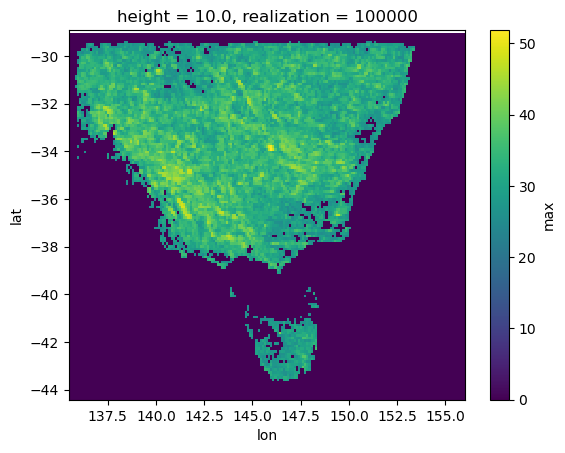

In [37]:
max_hist["max"].max("date").plot()

In [47]:
df = scws_hist.sum(("lat","lon")).to_dataframe()
df_barpar = (barpar_hist >= 0.83).sum(("lat","lon")).to_dataframe(name="bdsd")

In [48]:
days = []

years = np.arange(1985,2005)
df_ann = pd.DataFrame(index=years,columns=df.columns)
df_ann_barpar = pd.DataFrame(index=years,columns=df_barpar.columns)

for y in years:
    if y == 1985:
        months = [dt.datetime(y,12,1), dt.datetime(y+1,1,1)]
    else:
        months = [dt.datetime(y-1,12,1), dt.datetime(y,3,1)]

    df_ann.loc[y] =  df.loc[slice(months[0],months[1])].sum().T
    df_ann_barpar.loc[y] =  df_barpar.loc[slice(months[0],months[1])].sum().T
    
    days.append(df.loc[slice(months[0],months[1])].shape[0])
    
df_ann = df_ann.divide(pd.Series(days,index=years),axis=0)
df_ann_barpar = df_ann_barpar.divide(pd.DataFrame(days,index=years,columns=["bdsd"]),axis=0)


<Axes: >

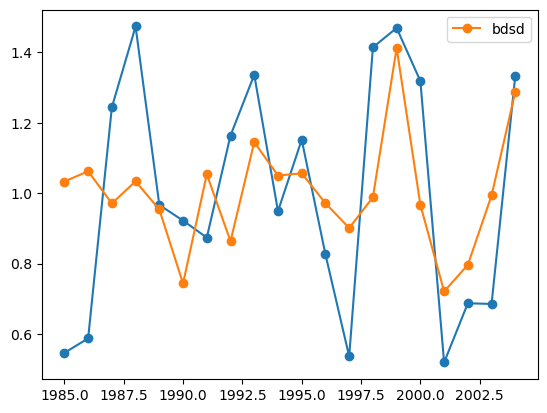

In [49]:
ax=plt.axes()
(df_ann / df_ann.mean()).drop(columns=["height","realization"]).all_events.plot(marker="o",ax=ax)
(df_ann_barpar / df_ann_barpar.mean()).drop(columns=["pseudo_level","realization"]).plot(ax=ax,marker="o")

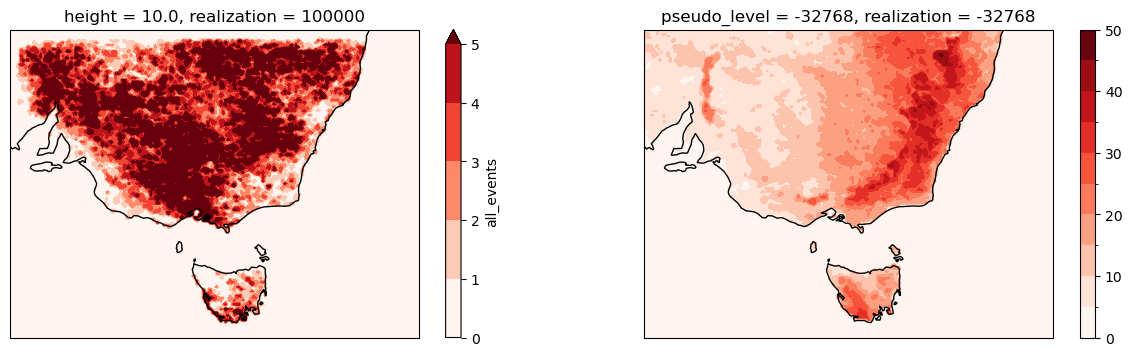

In [10]:
from scipy.ndimage import gaussian_filter

plt.figure(figsize=[15,4])
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
#xr.plot.contourf(scws_hist.all_events.sum("date") / (2006-1985),cmap=plt.get_cmap("Reds"), levels=[0,1,2,3,4,5])
xr.plot.contourf(scws_hist.all_events.sum("date"),cmap=plt.get_cmap("Reds"), levels=[0,1,2,3,4,5])
ax.coastlines()


ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
#xr.plot.contourf((barpar_hist>=0.83).sum("time") / (2006-1985),cmap=plt.get_cmap("Reds"), levels=11)
xr.plot.contourf((barpar_hist>=0.83).sum("time"),cmap=plt.get_cmap("Reds"), levels=11)
ax.coastlines()

In [106]:
scws_hist["bdsd"] = barpar_hist.rename({"time":"date"})

In [116]:
#LOOK AT CONDITIONAL PROBABILITY

In [117]:
#(( (scws_hist.bdsd >= 0.83) & (scws_hist.all_events)).mean("date") / ((scws_hist.all_events).mean("date"))).plot()

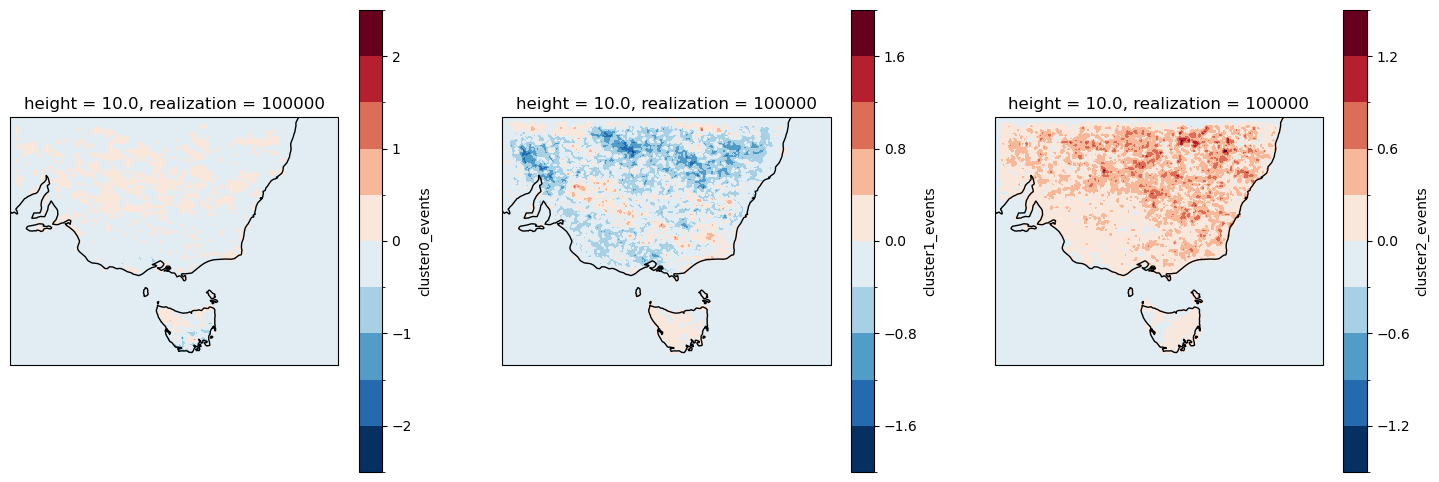

In [99]:
plt.figure(figsize=[18,6])
ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
xr.plot.contourf((scws_rcp.cluster0_events.sum("date",skipna=True) / (2060-2039)) - (scws_hist.cluster0_events.sum("date",skipna=True) / (2006-1985)),cmap=plt.get_cmap("RdBu_r"),levels=11)
ax.coastlines()

ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
xr.plot.contourf((scws_rcp.cluster1_events.sum("date") / (2060-2039)) - (scws_hist.cluster1_events.sum("date") / (2006-1985)),cmap=plt.get_cmap("RdBu_r"),levels=11)
ax.coastlines()

ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())
xr.plot.contourf((scws_rcp.cluster2_events.sum("date") / (2060-2039)) - (scws_hist.cluster2_events.sum("date") / (2006-1985)),cmap=plt.get_cmap("RdBu_r"),levels=11)
ax.coastlines()


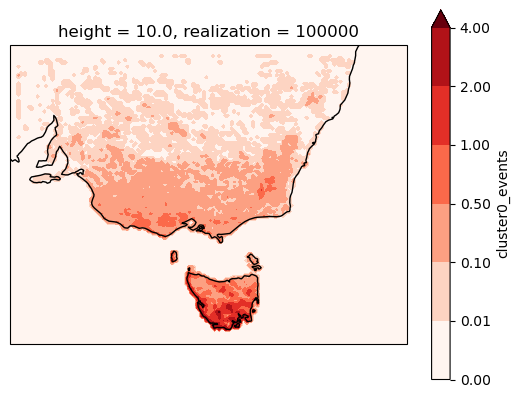

In [66]:
ax=plt.axes(projection=ccrs.PlateCarree())
xr.plot.contourf(scws_hist.cluster0_events.sum("date") / (2006-1985),cmap=plt.get_cmap("Reds"), levels=[0,0.01,0.1,0.5,1,2,4])
ax.coastlines()

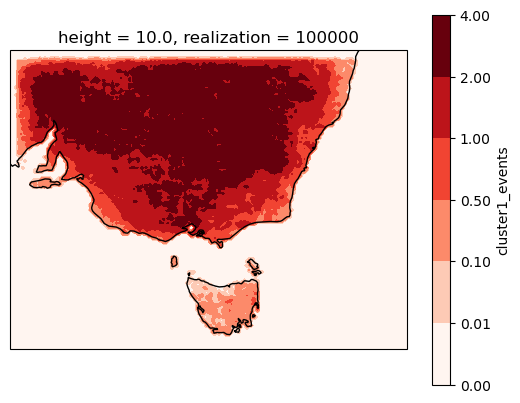

In [72]:
ax=plt.axes(projection=ccrs.PlateCarree())
xr.plot.contourf(scws_hist.cluster1_events.sum("date") / (2006-1985),cmap=plt.get_cmap("Reds"), levels=[0,0.01,0.1,0.5,1,2,4])
ax.coastlines()

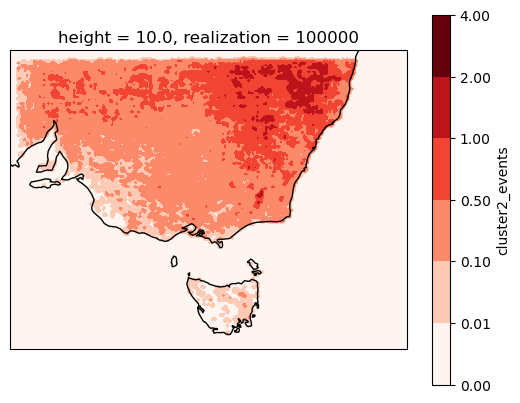

In [73]:
ax=plt.axes(projection=ccrs.PlateCarree())
xr.plot.contourf(scws_hist.cluster2_events.sum("date") / (2006-1985),cmap=plt.get_cmap("Reds"), levels=[0,0.01,0.1,0.5,1,2,4])
ax.coastlines()

In [69]:
#Read BARPAC-M ERA-forced data

barpac_erai = xr.open_mfdataset("/scratch/eg3/ab4502/barpa_scw_erai_historical_0_*.nc",chunks="auto")
barpac_access_hist = xr.open_mfdataset("/scratch/eg3/ab4502/barpa_scw_ACCESS1-0_historical_0_*.nc",chunks="auto")
barpac_access_rcp = xr.open_mfdataset("/scratch/eg3/ab4502/barpa_scw_ACCESS1-0_rcp85_0_*.nc",chunks="auto")

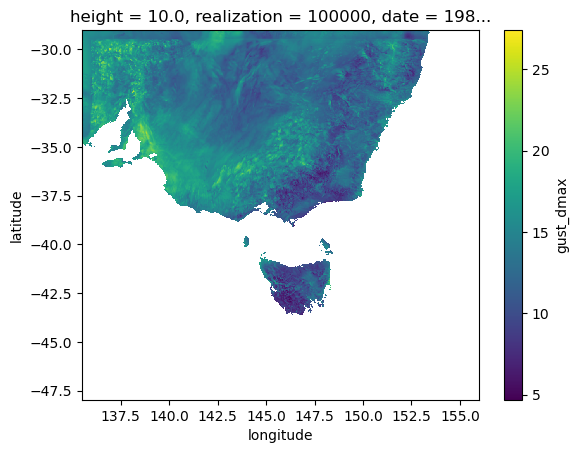

In [71]:
barpac_access_hist.isel(date=0).gust_dmax.plot()

In [20]:
xr.where(((barpac_erai.gust_dmax >= 25) & (barpac_erai.wgr_dmax >= 1.5) )*1,1,np.nan)

<xarray.DataArray (latitude: 948, longitude: 1024, date: 2254)>
dask.array<where, shape=(948, 1024, 2254), dtype=float64, chunksize=(948, 1024, 31), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -47.96 -47.94 -47.92 ... -29.06 -29.04 -29.02
  * longitude  (longitude) float32 135.5 135.5 135.5 135.6 ... 155.9 155.9 156.0
    height     float64 10.0
  * date       (date) datetime64[ns] 1990-12-01 1990-12-02 ... 2015-02-28

In [21]:
#Define SCW events where gust and wgr exceeds a threshold (say, 25 m/s and 1.5). Then coarsen the grid by only considering a max of one occurrence in a 50 x 50 box

scws = xr.where(((barpac_erai.gust_dmax >= 25) & (barpac_erai.wgr_dmax >= 1.5) ),1,np.nan).coarsen({"latitude":5,"longitude":5},boundary="trim",side="left").max(skipna=True).persist()
scws_hist = xr.where(((barpac_access_hist.gust_dmax >= 25) & (barpac_access_hist.wgr_dmax >= 1.5) ),1,np.nan).coarsen({"latitude":5,"longitude":5},boundary="trim",side="left").max(skipna=True).persist()
scws_rcp85 = xr.where(((barpac_access_rcp.gust_dmax >= 25) & (barpac_access_rcp.wgr_dmax >= 1.5) ),1,np.nan).coarsen({"latitude":5,"longitude":5},boundary="trim",side="left").max(skipna=True).persist()

#scws_hist0 = (((barpac_access_hist.gust_dmax >= 25) & (barpac_access_hist.wgr_dmax >= 1.5) & (barpac_access_hist.cluster==0) )*1).coarsen({"latitude":22,"longitude":22},boundary="trim",side="left").max(skipna=True).persist()
#scws_rcp0 = (((barpac_access_rcp.gust_dmax >= 25) & (barpac_access_rcp.wgr_dmax >= 1.5) & (barpac_access_rcp.cluster==0) )*1).coarsen({"latitude":22,"longitude":22},boundary="trim",side="left").max(skipna=True).persist()
# scws1 = (((barpac_erai.gust_dmax >= 25) & (barpac_erai.wgr_dmax >= 1.5) & (barpac_erai.cluster==1) )*1).coarsen({"latitude":11,"longitude":11},boundary="trim",side="left").max(skipna=True).persist()
# scws2 = (((barpac_erai.gust_dmax >= 25) & (barpac_erai.wgr_dmax >= 1.5) & (barpac_erai.cluster==2) )*1).coarsen({"latitude":11,"longitude":11},boundary="trim",side="left").max(skipna=True).persist()

In [7]:
#Do the same but for favourable environments
#Note that "cluster" here is defined as the cluster associated with the daily max gust, not the cluster associated with daily max BDSD

bdsd = ((barpac_erai.bdsd_dmax>=0.83)*1).coarsen({"latitude":5,"longitude":5},boundary="trim",side="left").max(skipna=True).persist()
bdsd_hist = ((barpac_access_hist.bdsd_dmax>=0.83)*1).coarsen({"latitude":5,"longitude":5},boundary="trim",side="left").max(skipna=True).persist()
bdsd_rcp = ((barpac_access_rcp.bdsd_dmax>=0.83)*1).coarsen({"latitude":5,"longitude":5},boundary="trim",side="left").max(skipna=True).persist()

# bdsd0 = ((barpac_erai.bdsd_dmax>=0.83) & (barpac_erai.cluster==0)*1).coarsen({"latitude":11,"longitude":11},boundary="trim",side="left").max(skipna=True).persist()
# bdsd1 = ((barpac_erai.bdsd_dmax>=0.83) & (barpac_erai.cluster==1)*1).coarsen({"latitude":11,"longitude":11},boundary="trim",side="left").max(skipna=True).persist()
# bdsd2 = ((barpac_erai.bdsd_dmax>=0.83) & (barpac_erai.cluster==2)*1).coarsen({"latitude":11,"longitude":11},boundary="trim",side="left").max(skipna=True).persist()

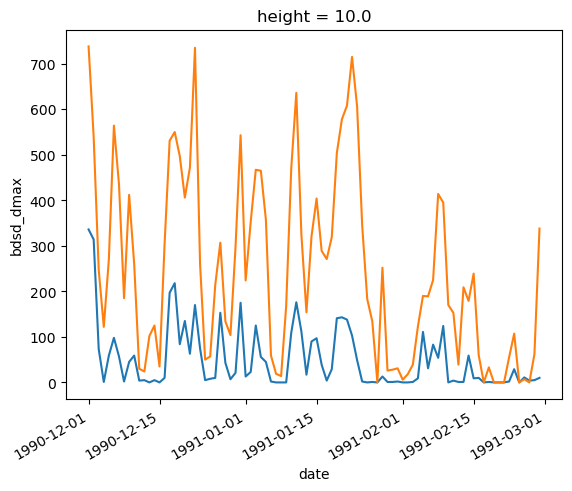

In [6]:
# scws.isel({"date":slice(0,90)}).sum(("latitude","longitude")).rolling(date=1).mean(min_periods=0,center=True).plot()

# bdsd.isel({"date":slice(0,90)}).sum(("latitude","longitude")).rolling(date=1).mean(min_periods=0,center=True).plot()

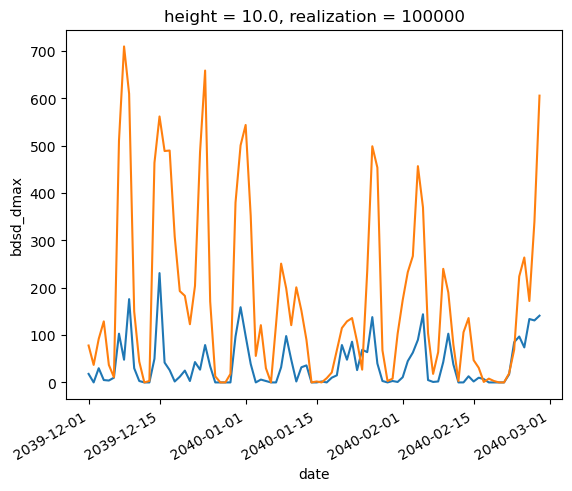

In [36]:
# scws_rcp85.isel({"date":slice(0,90)}).sum(("latitude","longitude")).rolling(date=1).mean(min_periods=0,center=True).plot()

# bdsd_rcp.isel({"date":slice(0,90)}).sum(("latitude","longitude")).rolling(date=1).mean(min_periods=0,center=True).plot()

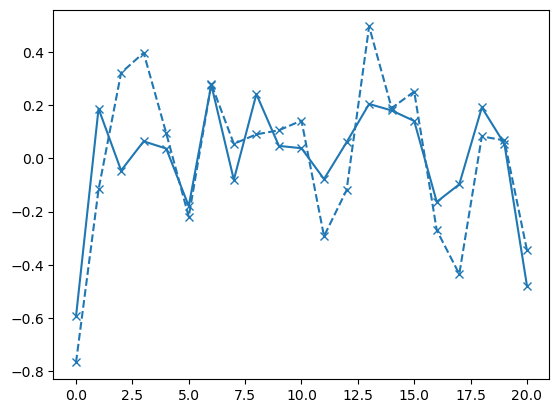

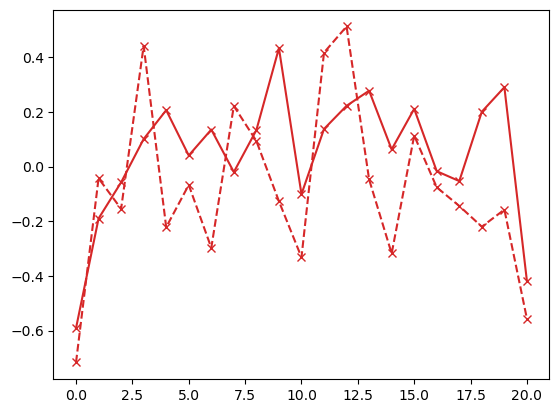

In [11]:
# scws_ts = scws_hist.sum(("latitude","longitude")).groupby("date.year").sum().values
# scws_ts_future = scws_rcp85.sum(("latitude","longitude")).groupby("date.year").sum().values
# scws_anom = (scws_ts - np.mean(scws_ts)) / np.mean(scws_ts)
# scws_anom_future = (scws_ts_future - np.mean(scws_ts)) / np.mean(scws_ts)

# bdsd_ts = bdsd_hist.sum(("latitude","longitude")).groupby("date.year").sum().values
# bdsd_ts_future = bdsd_rcp.sum(("latitude","longitude")).groupby("date.year").sum().values
# bdsd_anom = (bdsd_ts - np.mean(bdsd_ts)) / np.mean(bdsd_ts)
# bdsd_anom_future = (bdsd_ts_future - np.mean(bdsd_ts)) / np.mean(bdsd_ts)

# plt.plot(scws_anom,marker="x",color="tab:blue",ls="--")
# plt.plot(bdsd_anom,marker="x",color="tab:blue",ls="-")

# plt.figure()
# plt.plot(scws_anom_future,marker="x",color="tab:red",ls="--")
# plt.plot(bdsd_anom_future,marker="x",color="tab:red",ls="-")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


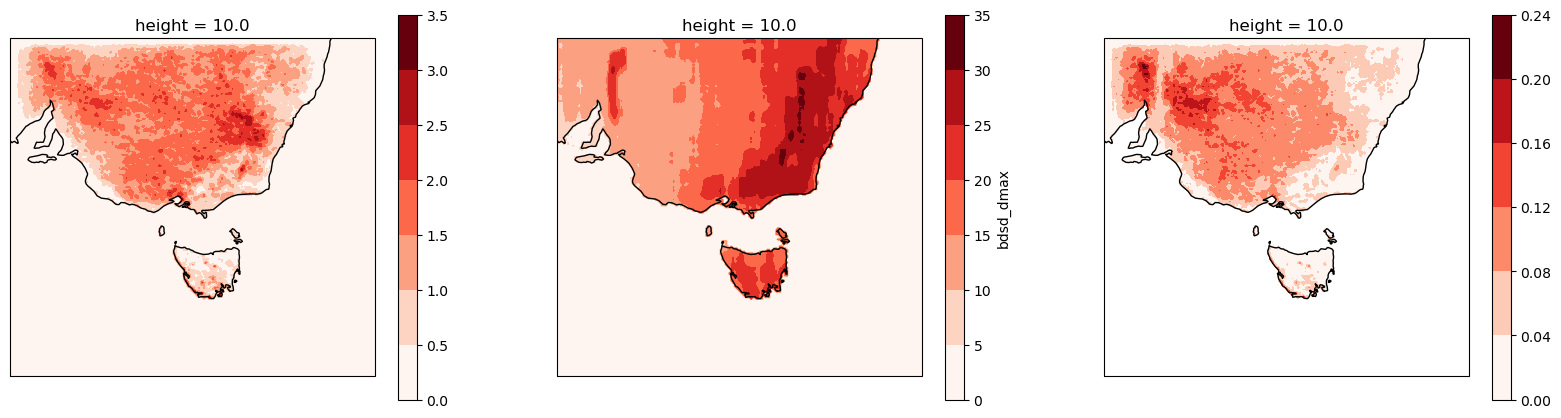

In [8]:
plt.figure(figsize=[20,5])

ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
xr.plot.contourf(scws.sum("date") / (2016-1990),cmap=plt.get_cmap("Reds"),ax=ax,levels=8)
ax.coastlines()

ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
xr.plot.contourf(bdsd.sum("date") / (2016-1990),cmap=plt.get_cmap("Reds"),ax=ax,levels=8)
ax.coastlines()

ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())
xr.plot.contourf(scws.sum("date") / bdsd.sum("date"),cmap=plt.get_cmap("Reds"),ax=ax,levels=8)
ax.coastlines()

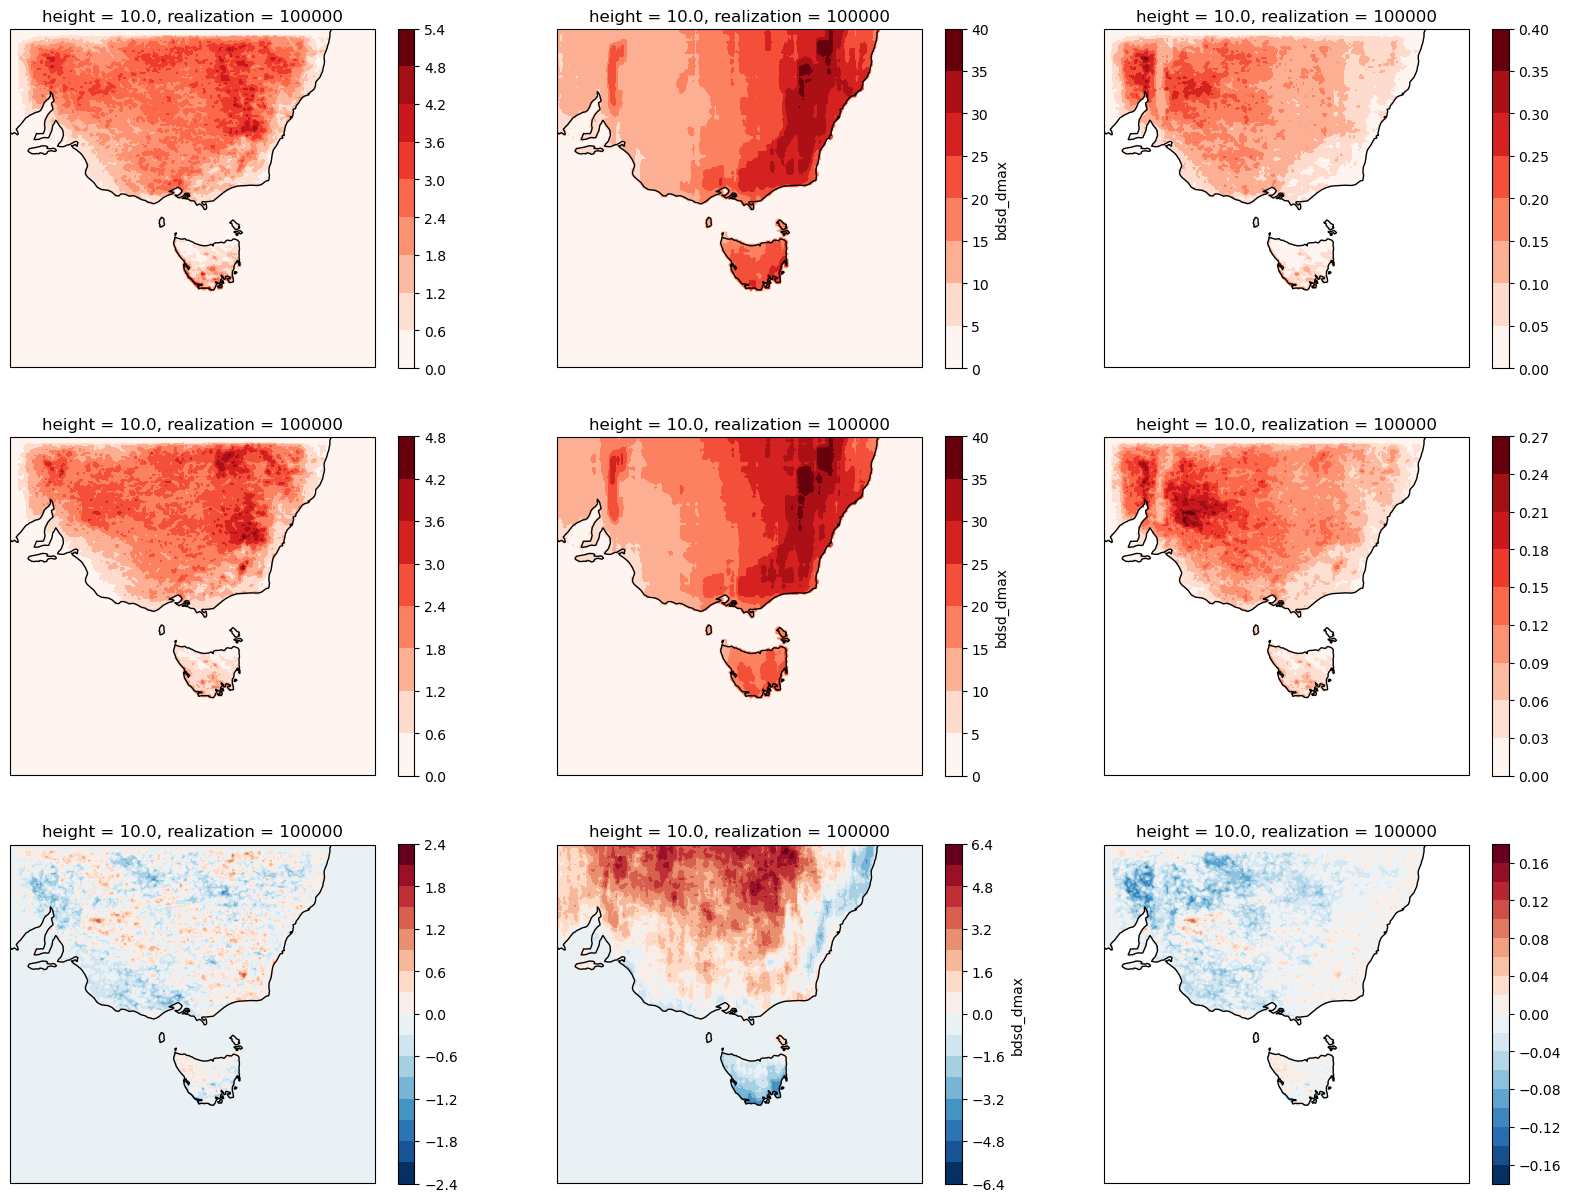

In [9]:
plt.figure(figsize=[20,15])

ax=plt.subplot(3,3,1,projection=ccrs.PlateCarree())
xr.plot.contourf(scws_hist.sum("date") / (2006-1985),cmap=plt.get_cmap("Reds"),ax=ax,levels=10)
ax.coastlines()

ax=plt.subplot(3,3,2,projection=ccrs.PlateCarree())
xr.plot.contourf(bdsd_hist.sum("date") / (2006-1985),cmap=plt.get_cmap("Reds"),ax=ax,levels=10)
ax.coastlines()

ax=plt.subplot(3,3,3,projection=ccrs.PlateCarree())
xr.plot.contourf(scws_hist.sum("date") / bdsd_hist.sum("date"),cmap=plt.get_cmap("Reds"),ax=ax,levels=10)
ax.coastlines()


ax=plt.subplot(3,3,4,projection=ccrs.PlateCarree())
xr.plot.contourf(scws_rcp85.sum("date") / (2060-2039),cmap=plt.get_cmap("Reds"),ax=ax,levels=10)
ax.coastlines()

ax=plt.subplot(3,3,5,projection=ccrs.PlateCarree())
xr.plot.contourf(bdsd_rcp.sum("date") / (2060-2039),cmap=plt.get_cmap("Reds"),ax=ax,levels=10)
ax.coastlines()

ax=plt.subplot(3,3,6,projection=ccrs.PlateCarree())
xr.plot.contourf(scws_rcp85.sum("date") / bdsd_rcp.sum("date"),cmap=plt.get_cmap("Reds"),ax=ax,levels=10)
ax.coastlines()

ax=plt.subplot(3,3,7,projection=ccrs.PlateCarree())
xr.plot.contourf(
    scws_rcp85.sum("date") / (2060-2039) - 
    scws_hist.sum("date") / (2006-1985)
    ,cmap=plt.get_cmap("RdBu_r"),ax=ax,levels=20)
ax.coastlines()

ax=plt.subplot(3,3,8,projection=ccrs.PlateCarree())
xr.plot.contourf(
    bdsd_rcp.sum("date") / (2060-2039) - 
    bdsd_hist.sum("date") / (2006-1985),cmap=plt.get_cmap("RdBu_r"),ax=ax,levels=20)
ax.coastlines()

ax=plt.subplot(3,3,9,projection=ccrs.PlateCarree())
xr.plot.contourf(scws_rcp85.sum("date") / bdsd_rcp.sum("date") - 
                 scws_hist.sum("date") / bdsd_hist.sum("date"),cmap=plt.get_cmap("RdBu_r"),ax=ax,levels=20)
ax.coastlines()

In [31]:
from merge_data import last_day_of_month
import os
import datetime as dt
import dask

files = []
for y in np.arange(1985,2006):
    for m in [12,1,2]:
        date = dt.datetime(y,m,1)
        path = "/g/data/eg3/ab4502/ExtremeWind/aus/barpa_access/barpa_access_"+date.strftime("%Y%m%d")+"_"+last_day_of_month(dt.datetime(y,m,1)).strftime("%Y%m%d")+".nc"
        if (os.path.isfile(path)) & (date>=dt.datetime(1985,12,1)) & (date < dt.datetime(2005,3,1)):
            files.append(path)
        else:
            print("Skipping "+date.strftime("%Y%m%d")+"...")
            
barpar_hist = xr.open_mfdataset(files)

Skipping 19850101...
Skipping 19850201...
Skipping 20051201...


In [32]:
files = []
for y in np.arange(2039,2060):
    for m in [12,1,2]:
        date = dt.datetime(y,m,1)
        path = "/g/data/eg3/ab4502/ExtremeWind/aus/barpa_access/barpa_access_"+date.strftime("%Y%m%d")+"_"+last_day_of_month(dt.datetime(y,m,1)).strftime("%Y%m%d")+".nc"
        if (os.path.isfile(path)) & (date>=dt.datetime(2039,12,1)) & (date < dt.datetime(2059,3,1)):
            files.append(path)
        else:
            print("Skipping "+date.strftime("%Y%m%d")+"...")
            
barpar_rcp = xr.open_mfdataset(files)

Skipping 20390101...
Skipping 20390201...
Skipping 20591201...


In [33]:
barpar_bdsd_hist = barpar_hist["bdsd"].coarsen({"time":4}).max().persist()
barpar_bdsd_rcp = barpar_rcp["bdsd"].coarsen({"time":4}).max().persist()


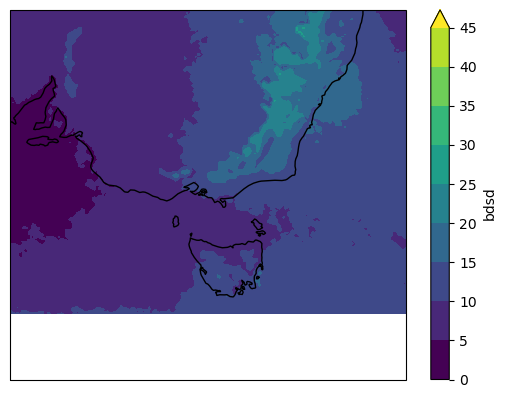

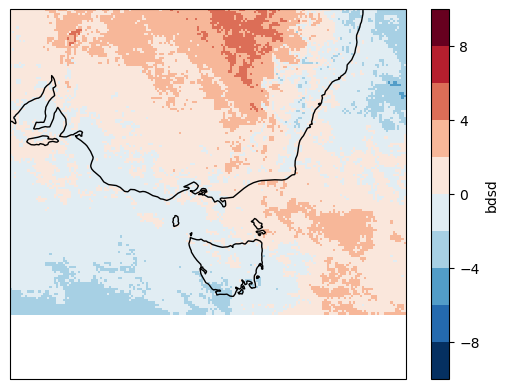

In [34]:
plt.figure()

ax=plt.axes(projection=ccrs.PlateCarree())
xr.plot.contourf((barpar_bdsd_hist >= 0.83).sum("time") / (2006-1985), levels=np.linspace(0,45,10))
plt.ylim([-47.75, -29.27])
plt.xlim([135.7,155.5])
ax.coastlines()

plt.figure()

ax=plt.axes(projection=ccrs.PlateCarree())
xr.plot.pcolormesh(
    ((barpar_bdsd_rcp >= 0.83).sum("time") / (2006-1985)) - 
    ((barpar_bdsd_hist >= 0.83).sum("time") / (2060-2039)), levels=10)
plt.ylim([-47.75, -29.27])
plt.xlim([135.7,155.5])
ax.coastlines()

In [ ]:
#For comparison, get the same for ERA5

files = []
for y in np.arange(5,16):
    files = files + (list(glob.glob("/g/data/eg3/ab4502/ExtremeWind/aus/era5/era5_20"+str(y).zfill(2)+"01*") + \
                glob.glob("/g/data/eg3/ab4502/ExtremeWind/aus/era5/era5_20"+str(y).zfill(2)+"02*") + \
                glob.glob("/g/data/eg3/ab4502/ExtremeWind/aus/era5/era5_20"+str(y).zfill(2)+"12*")))
era5 = xr.open_mfdataset(files).sel(lat=slice(barpac.latitude.max(),barpac.latitude.min()),
                                    lon=slice(barpac.longitude.min(),barpac.longitude.max()))
era5_bdsd = calc_bdsd(era5.sel(time=np.in1d(era5.time.dt.hour, [0,6,12,18])))["bdsd"].coarsen({"time":4}).max().persist()

In [ ]:
#Compare SCW (environment) frequency between BARPAC-M, BARPA-R and ERA5.
#Note these are all on different grids at the moment.

plt.figure(figsize=[18,5])

ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
xr.plot.contourf(scws.sum("date") / 11,cmap=plt.get_cmap("Reds"),ax=ax,levels=10)
ax.coastlines()

ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
xr.plot.contourf((bdsd >= 0.8).sum("time") / 11,cmap=plt.get_cmap("Reds"),ax=ax,levels=10)
ax.coastlines()

ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())
xr.plot.contourf((era5_bdsd >= 0.8).sum("time") / 11,cmap=plt.get_cmap("Reds"),ax=ax,levels=10)
ax.coastlines()

In [ ]:
#Look at BARPAC-M occurrences for each cluster

scws0 = (((barpac.gust_dmax >= 20) & (barpac.wgr_dmax >= 1.5) & (barpac.lightning100 >= 1) & (barpac.cluster==0))*1).coarsen({"latitude":5,"longitude":5},boundary="trim").max(skipna=True).persist()
scws1 = (((barpac.gust_dmax >= 20) & (barpac.wgr_dmax >= 1.5) & (barpac.lightning100 >= 1) & (barpac.cluster==1))*1).coarsen({"latitude":5,"longitude":5},boundary="trim").max(skipna=True).persist()
scws2 = (((barpac.gust_dmax >= 20) & (barpac.wgr_dmax >= 1.5) & (barpac.lightning100 >= 1) & (barpac.cluster==2))*1).coarsen({"latitude":5,"longitude":5},boundary="trim").max(skipna=True).persist()

plt.figure(figsize=[18,5])
ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
xr.plot.contourf(scws0.sum("date") / 11,cmap=plt.get_cmap("Reds"),ax=ax,levels=10)
ax.coastlines()

ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
xr.plot.contourf(scws1.sum("date") / 11,cmap=plt.get_cmap("Greens"),ax=ax,levels=10)
ax.coastlines()

ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())
xr.plot.contourf(scws2.sum("date") / 11,cmap=plt.get_cmap("Blues"),ax=ax,levels=10)
ax.coastlines()